In [1]:
import numpy as np
import h2o
import matplotlib.pyplot as plt

In [95]:
def get_data(path, shuffle=True):
    # images are 48x48 = 2304 size vectors
    X = []
    Y = []
    first = True
    for line in open(path):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])
    X, Y = np.array(X) / 255.0, np.array(Y)
    if shuffle:
        idx = list(range(len(Y)))
        np.random.shuffle(idx)
        X = X[idx]
        Y = Y[idx]
    # the followign equivalent to np.hstack([Y.reshape(-1,1), X])
    return np.c_[Y, X]


def show_im(data):
    cls = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']
    while True:
        for i in range(7):
            x = data[data[:,0] == i, 1:]
            j = np.random.choice(len(x))
            n_pixel = int(np.sqrt(x.shape[1]))
            plt.imshow(x[j].reshape(n_pixel, n_pixel))
            plt.title(cls[i])
            plt.show()
        if input('Quit? (Y/n):') == 'Y':
            break

In [83]:
h2o.init(nthreads=7, max_mem_size='7g')
#h2o.cluster().show_status()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "9.0.4"; Java(TM) SE Runtime Environment (build 9.0.4+11); Java HotSpot(TM) 64-Bit Server VM (build 9.0.4+11, mixed mode)
  Starting server from /Users/sasha/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/5y/mj4r62nd1rj16b_8rrtk_tv00000gn/T/tmpuet1p_ac
  JVM stdout: /var/folders/5y/mj4r62nd1rj16b_8rrtk_tv00000gn/T/tmpuet1p_ac/h2o_sasha_started_from_python.out
  JVM stderr: /var/folders/5y/mj4r62nd1rj16b_8rrtk_tv00000gn/T/tmpuet1p_ac/h2o_sasha_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Zurich
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,17 days
H2O cluster name:,H2O_from_python_sasha_2wu7p4
H2O cluster total nodes:,1
H2O cluster free memory:,7 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,7
H2O cluster status:,"accepting new members, healthy"


In [ ]:
# Import the FER data as a single numpy matrix, without splitting into X and Y.
# H2O takes a single data frame as input, together with column names identifying x (predictors) and y (targets).
# One could also import X and Y to the h2o cluster as distinct h2o data frames, and then combine them with .cbind().
# e.g.: instead of data_h2o below, one creates x_h2o and y_h2o, then data_h2o = y_h2o.cbind(x_h2o).
data_np = get_data('../large_data/fer/fer2013.csv', shuffle=True)

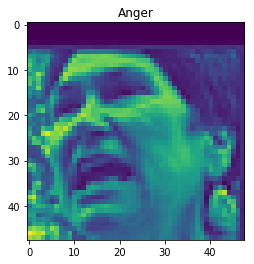

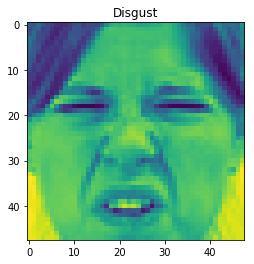

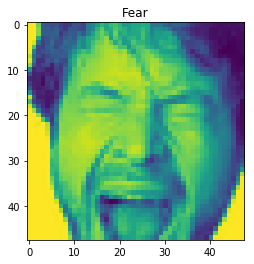

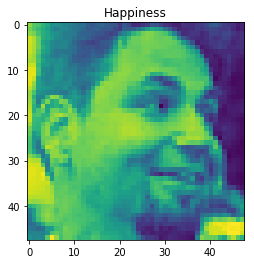

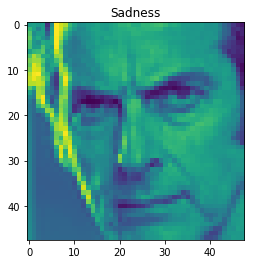

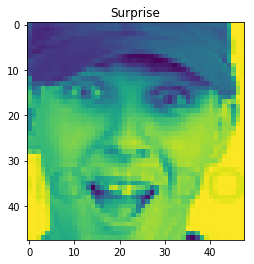

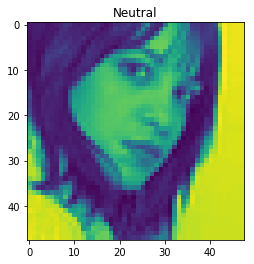

Quit? (Y/n):Y


In [96]:
show_im(data_np)

In [97]:
# Load the data to the h2o cluster (JVM).
h2o.remove_all()
data_h2o = h2o.H2OFrame(data_np)
# Identify predictors and response
y = data_h2o.columns[0]
x = data_h2o.columns; x.remove(y)
# For categorical classification, response should be a factor
data_h2o[y] = data_h2o[y].asfactor()

In [128]:
# Split the data into Train/Test/Validation, having 80%/16%/4% of the data respectively.
#train,test,valid = data_h2o.split_frame(ratios=[.8, .16])

# Print number of samples per data frame
print(f'train.nrow: {train.nrow}')
print(f' test.nrow: {test.nrow}')
print(f'valid.nrow: {valid.nrow}')

# Print distribution of samples across classes, per data frame
def samples_per_class(df, pct=True):
    count_samples = [int((df[y]==i).sum()) for i in data_h2o[y].levels()[0]]
    if pct:
        count_samples = count_samples / np.sum(count_samples)
    return count_samples

def format_list(l:list, fmt):
    return ", ".join(["{:"+fmt+"}"]*len(l)).format(*l)

print("train dist.: " + format_list(samples_per_class(train), '.2f'))
print("valid dist.: " + format_list(samples_per_class(valid), '.2f'))
print("test dist. : " + format_list(samples_per_class(test), '.2f'))

train.nrow: 28806
 test.nrow: 5669
valid.nrow: 1412
train dist.: 0.14, 0.02, 0.14, 0.25, 0.17, 0.11, 0.17
valid dist.: 0.13, 0.02, 0.15, 0.25, 0.17, 0.11, 0.17
test dist.: 0.14, 0.01, 0.14, 0.24, 0.17, 0.11, 0.18


In [ ]:
# In memory we now have the complete data frame, the splitter, and the three splitted data frames.
h2o.ls()

In [89]:
# Perform random grid search to test some choices of hyperparameters.
# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html

# Random search criteria
search_criteria = {'strategy': 'RandomDiscrete',
                   'max_runtime_secs': 3600,  # up to 1 hour
                   'stopping_rounds': 5,
                   'stopping_metric': 'misclassification',
                   'stopping_tolerance': 1e-2, 
                   'seed': 1234}

# Fixed hyperparameters
dlm_hyper = {'loss': 'cross_entropy',
             'distribution': 'multinomial',
             'adaptive_rate': True,  # ADADELTA
             'mini_batch_size': 500,
             'epochs': 15,
             'balance_classes': True,  # since we have severe class imbalance
             'input_dropout_ratio': 0.2}

# Hyperparameter space for random search
dlm_hyper_s = {#'rate': [10**(-i) for i in range(1,5)],  # ignored if adaptive_rate==True
               'hidden': [100, 200, [20, 20]],  # 3
               'activation': ['RectifierWithDropout', 'TanhWithDropout']}  # 3*2=6 models

# Train and validate a random grid of deep learning models
dlm_search1 = h2o.grid.grid_search.H2OGridSearch(
    model=h2o.estimators.deeplearning.H2ODeepLearningEstimator(**dlm_hyper),
    grid_id='dlm_search1',
    hyper_params=dlm_hyper_s,
    search_criteria=search_criteria)
dlm_search1.train(x=x, y=y, training_frame=train, validation_frame=valid, seed=1)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%


In [90]:
# Get the grid results, sorted by accuracy
dlm_grid1 = dlm_search1.get_grid(sort_by='accuracy', decreasing=True)
dlm_grid1

# Grab the top model
dlm1 = dlm_grid1.models[0]

               activation    hidden            model_ids             accuracy
0    RectifierWithDropout     [200]  dlm_search1_model_3  0.39713261648745524
1    RectifierWithDropout     [100]  dlm_search1_model_5    0.396415770609319
2         TanhWithDropout     [200]  dlm_search1_model_6  0.31182795698924726
3    RectifierWithDropout  [20, 20]  dlm_search1_model_4   0.3046594982078853
4         TanhWithDropout     [100]  dlm_search1_model_2  0.29605734767025094
5         TanhWithDropout  [20, 20]  dlm_search1_model_1  0.23512544802867386


In [147]:
# Now let's evaluate the model performance on a test set
# so we get a honest estimate of model performance
dlm1_perf = dlm1.model_performance(test)
print(f"mean_per_class_error: {dlm1_perf.mean_per_class_error()}")
dlm1_perf.confusion_matrix()

mean_per_class_error: 0.8575261199655874
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,5,6,Error,Rate
0.0,0.0,0.0,803.0,6.0,0.0,0.0,1.0,809 / 809
0.0,0.0,0.0,78.0,0.0,0.0,0.0,1.0,78 / 78
0.0,0.0,0.0,813.0,3.0,0.0,0.0,1.0,816 / 816
0.0,0.0,0.0,1357.0,8.0,0.0,0.0,0.0058608,8 / 1.365
0.0,0.0,0.0,941.0,3.0,0.0,0.0,0.9968220,941 / 944
0.0,0.0,0.0,638.0,0.0,0.0,0.0,1.0,638 / 638
0.0,0.0,0.0,1015.0,4.0,0.0,0.0,1.0,1.019 / 1.019
0.0,0.0,0.0,5645.0,24.0,0.0,0.0,0.7600988,4.309 / 5.669


In [ ]:
# Save model and test data
model_path = h2o.save_model(model=dlm1, path="out/h2o_models", force=True)

In [159]:
# Load model and test data
saved_model = h2o.load_model(model_path)
saved_model_perf = saved_model.model_performance(test)
print(f"mean_per_class_error: {dlm1_perf.mean_per_class_error()}")
dlm1_perf.confusion_matrix()

mean_per_class_error: 0.8575261199655874
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,5,6,Error,Rate
0.0,0.0,0.0,803.0,6.0,0.0,0.0,1.0,809 / 809
0.0,0.0,0.0,78.0,0.0,0.0,0.0,1.0,78 / 78
0.0,0.0,0.0,813.0,3.0,0.0,0.0,1.0,816 / 816
0.0,0.0,0.0,1357.0,8.0,0.0,0.0,0.0058608,8 / 1.365
0.0,0.0,0.0,941.0,3.0,0.0,0.0,0.9968220,941 / 944
0.0,0.0,0.0,638.0,0.0,0.0,0.0,1.0,638 / 638
0.0,0.0,0.0,1015.0,4.0,0.0,0.0,1.0,1.019 / 1.019
0.0,0.0,0.0,5645.0,24.0,0.0,0.0,0.7600988,4.309 / 5.669


In [160]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? Y
